In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, hstack
import sys, os
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')

In [2]:
from hsc_gaap.gaap import consolidateMerianCats
import itertools

Overriding default configuration file with /projects/HSC/LSST/stack_20220527/conda/envs/lsst-scipipe-4.1.0/share/eups/Linux64/dustmaps_cachedata/g41a3ec361e+62d12e78cb/config/.dustmapsrc


In [197]:
tract = 9813

In [211]:
old_patches = [name for name in os.listdir(
    f"/projects/MERIAN/repo/S20A/deepCoadd_calexp/{tract}/")]
new_patches = [int(name[0]) + int(name[2]) * 9 for name in old_patches]

import lsst.daf.butler as dafButler
butler = dafButler.Butler("/projects/MERIAN/repo")
merian_patches = [item.dataId['patch'] for item in butler.registry.queryDatasets('objectTable', 
                              dataId=dict(tract=tract), collections='DECam/runs/merian/dr1_wide',
                              instrument='DECam',
                              skymap='hsc_rings_v1')]
merian_patches = np.unique(merian_patches)
common_patches = np.intersect1d(new_patches, merian_patches)
# common_patches = [(patch%9, patch//9) for patch in common_patches]
print(f'In tract = {tract}, there are {len(common_patches)} common patches')

In tract = 9813, there are 66 common patches


In [199]:
# patch_cols = [0,1,2,3,4,5,6,7,8]
# patch_rows = [0,1,2,3,4,5,6,7,8]

patches_old = common_patches #list(itertools.product(patch_cols, patch_rows))

In [212]:
print(common_patches)

[ 0  1  2  4  5  6  7  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 27
 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 45 46 47 48 49 50 51 52 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 79]


In [200]:
import time

In [201]:
filedir = f'/projects/MERIAN/repo/S20A/gaapTable/{tract}/'

good_patches = []

for patch in patches_old:
    patch_name = f'{patch[0]},{patch[1]}'
    filename = os.path.join(filedir, patch_name, f'objectTable_{tract}_{patch_name}_S20A.fits')
    if os.path.isfile(filename):
        filesize = os.path.getsize(filename) / 1024**2
        fileday = time.gmtime(os.path.getmtime(filename)).tm_mday
#         print("File Size is :", filesize, "Mb")
        if filesize > 100 and fileday > 22:
            good_patches.append(patch)
        else:
            print(patch_name, 'is not good!', 'Filesize = ', filesize)
    else:
        print(patch_name, ', No such file')

In [204]:
print('Total number of patches:', len(patches_old))
print('Good patches:', len(good_patches))

Total number of patches: 66
Good patches: 66


---

### Concatenate all patches

In [206]:
from hsc_gaap.gaap import consolidateObjectTables

In [207]:
cat = consolidateObjectTables([patch[0] + patch[1] * 9 for patch in good_patches])

In [209]:
cat.write(f'/projects/MERIAN/repo/S20A/gaapTable/{tract}/objectTable_S20A_{tract}_221224.fits')
# cat.write(f'/tigress/jiaxuanl/public_html/Merian/objectTable_S20A_{tract}_221208.fits', overwrite=True)

In [ ]:
cat = joinCatPatches(patches=[22, 23, 24, 25, 31, 32, 33, 34, 40, 41, 42, 43], filters='gri', hsc_type='S20A')

In [ ]:
cat.write('/tigress/jiaxuanl/public_html/Merian/gri_S20A_patch22_43.fits', overwrite=True)

In [32]:
merian = joinMerianCatPatches(patches=[22, 23, 24, 25], tract=9813)

In [33]:
merian.write('/tigress/jiaxuanl/public_html/Merian/Merian_patch22_25.fits', overwrite=True)

In [34]:
np.sum(cat['id'] != merian['objectId'])

0

---

### Let's only keep several columns, and make the excess plot

#### Manual `gaap`

In [238]:
# hstack with Merian
tract = 9813
cats = []
for patch in tqdm(good_patches[:]):
    patch_name = f'{patch[0]},{patch[1]}'
    
    new_patch = patch[0] + patch[1] * 9
    filename = os.path.join(filedir, patch_name, f'objectTable_{tract}_{patch_name}_S20A.fits')
    cat = Table.read(filename)
    merian = consolidateMerianCats([new_patch], tract=tract)
    if np.sum(merian['objectId'] != cat['objectId']) > 0:
        raise ValueError('Merian catalog does not match with HSC catalog')
    else:
        # only photometry columns
        merian_cols = ['coord_ra', 'coord_dec', 'ebv', 'sky_object', 'deblend_nChild', 'tract', 'patch'
        ] + [item for item in merian.colnames if 'gaap' in item or 'blendedness' in item or 'psfF' in item]
        hsc_cols = [item for item in cat.colnames if 'gaap' in item or 'blendedness' in item or 'psfF' in item]

        cat = hstack([merian[merian_cols], cat[hsc_cols]])
    
        cats.append(cat)
    
#         cat = hstack([merian, cat[hsc_cols]]).to_pandas()
#         # Have to save in H5 since there are >999 columns in the table
#         # FITS cannot handle it
        
#         filename = os.path.join(filedir, patch_name, f'objectTable_9813_{patch_name}_S20A_MDR1.h5')
#         cat.to_hdf(filename, key='df', mode='w')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [02:58<00:00,  2.70s/it]


In [239]:
from astropy.table import vstack

In [240]:
temp = vstack(cats)

In [241]:
temp.write('/projects/MERIAN/repo/S20A/gaapTable/9813/objectTable_S20A_Merian_9813_221224.fits')

In [ ]:
# Then cross-match with Yifei's catalog on laptop

#### W40

In [299]:
old_patches = [name for name in os.listdir(
    f"/projects/MERIAN/repo/S20A/deepCoadd_calexp/{tract}/")]
new_patches = [int(name[0]) + int(name[2]) * 9 for name in old_patches]

import lsst.daf.butler as dafButler
butler = dafButler.Butler('/projects/HSC/repo/main')
w40_patches = [item.dataId['patch'] for item in butler.registry.queryDatasets('objectTable', 
                              dataId=dict(tract=tract), collections='HSC/runs/RC2/w_2022_40/DM-36151',
                              instrument='HSC',
                              skymap='hsc_rings_v1')]
w40_patches = np.unique(w40_patches)
common_patches = np.intersect1d(new_patches, w40_patches)
common_patches = [(patch%9, patch//9) for patch in common_patches]
print(f'In tract = {tract}, there are {len(common_patches)} common patches')

In tract = 9813, there are 66 common patches


In [308]:
# hstack with Merian
tract = 9813
cats = []
for patch in tqdm(common_patches[:]):
    patch_name = f'{patch[0]},{patch[1]}'
    
    new_patch = patch[0] + patch[1] * 9
    # W40
    butler = dafButler.Butler('/projects/HSC/repo/main')
    dataId = dict(tract=tract, patch=new_patch)
    cat = butler.get(
        'objectTable',
        collections='HSC/runs/RC2/w_2022_40/DM-36151',
        dataId=dataId,
        instrument='HSC',
        skymap='hsc_rings_v1',
    )
    cat = Table.from_pandas(cat)
#     merian = consolidateMerianCats([new_patch], tract=tract)
#     if np.sum(merian['objectId'] != cat['objectId']) > 0:
#         raise ValueError('Merian catalog does not match with HSC catalog')
#     else:
    # only photometry columns
    merian_cols = ['coord_ra', 'coord_dec', 'ebv', 'sky_object', 'deblend_nChild', 'tract', 'patch'
    ] + [item for item in merian.colnames if 'gaap' in item or 'blendedness' in item or 'psfF' in item]
    hsc_cols = ['coord_ra', 'coord_dec', 'ebv', 'sky_object', 'deblend_nChild', 'tract', 'patch'
    ] + [item for item in cat.colnames if 'gaap' in item or 'blendedness' in item or 'psfF' in item]

    cat = cat[hsc_cols]

    cats.append(cat)
    
#         cat = hstack([merian, cat[hsc_cols]]).to_pandas()
#         # Have to save in H5 since there are >999 columns in the table
#         # FITS cannot handle it
        
#         filename = os.path.join(filedir, patch_name, f'objectTable_9813_{patch_name}_S20A_MDR1.h5')
#         cat.to_hdf(filename, key='df', mode='w')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [01:50<00:00,  1.67s/it]


In [309]:
temp = vstack(cats)

In [310]:
temp.write('/projects/MERIAN/repo/S20A/gaapTable/9813/objectTable_w40_9813.fits')

---

### Excess plot

In [242]:
import astropy.units as u
from astropy.coordinates import SkyCoord

In [312]:
cat = Table.read('/projects/MERIAN/repo/S20A/gaapTable/9813/cosmos_merian_dr1_gaap_221224.fits')

In [248]:
import kuaizi
kuaizi.set_matplotlib(style='JL', usetex=True, dpi=80, fontsize=20)

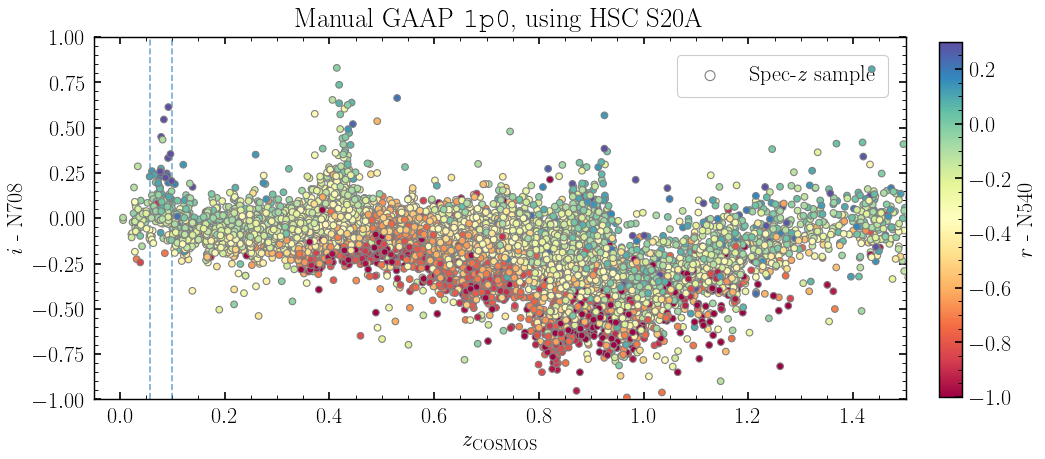

In [250]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), sharey=True)

plt.sca(axes)
hsc_type = 'S20A'
aper = '1p0'
flag = cat['spec_z']
sct = plt.scatter(cat['z_cosmos'][flag],
                  - 2.5 * np.log10(cat[f'i_gaap{aper}Flux'] /
                           cat[f'N708_gaap{aper}Flux'])[flag],
                  c=-2.5 * np.log10(cat[f'r_gaap{aper}Flux'] /
                           cat[f'N540_gaap{aper}Flux'])[flag],
                  cmap='Spectral', vmin=-1.0, vmax=0.3, 
                  edgecolors='gray', zorder=30, label='Spec-$z$ sample')

# sct = plt.scatter(cat['z_cosmos'][~flag],
#                   - 2.5 * np.log10(cat[f'i_gaap{aper}Flux'] /
#                            cat[f'N708_gaap{aper}Flux'])[~flag],
#                   c=-2.5 * np.log10(cat[f'r_gaap{aper}Flux'] /
#                            cat[f'N540_gaap{aper}Flux'])[~flag],
#                   cmap='Spectral', vmin=-1.0, vmax=0.3, edgecolors='none', 
#                   label='Photo-$z$ sample')

plt.axvline(0.058, ls='--', alpha=0.6)
plt.axvline(0.10, ls='--', alpha=0.6)
plt.ylim(-1, 1.0)
plt.xlim(-0.05, 1.5)
plt.title(r'Manual GAAP $\texttt{1p0}$, ' + f'using HSC {hsc_type}')
plt.xlabel('$z_\mathrm{COSMOS}$')
plt.ylabel('$i$ - N708')
leg = plt.legend(loc='upper right', fontsize=20, scatterpoints=1, frameon=True, markerscale=1.5)
leg.legendHandles[0].set_facecolor('none')


fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.13, 0.02, 0.74])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label('$r$ - N540')
# for t in cbar.ax.get_label():
#     t.set_fontsize(18)

# # fig.colorbar(im, cax=cax, orientation='vertical')
# fig.colorbar(sct, cax=cax, label='$r$ - N540', )
plt.subplots_adjust(wspace=0.05)
# plt.savefig(f'/tigress/jiaxuanl/public_html/Merian/manual_gaap_excess_plot_{hsc_type}.png', 
#             dpi=100, bbox_inches='tight')

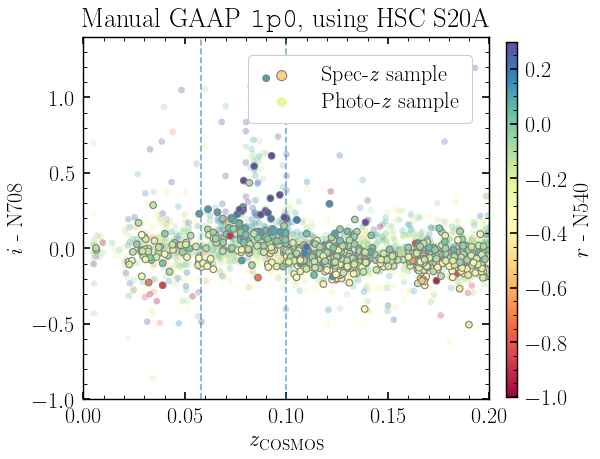

In [314]:
fig, axes = plt.subplots(1, 1, figsize=(7, 6), sharey=True)

plt.sca(axes)
hsc_type = 'S20A'
aper = '1p0'
flag = cat['spec_z']
sct = plt.scatter(cat['z_cosmos'][flag],
                  - 2.5 * np.log10(cat[f'i_gaap{aper}Flux'] /
                           cat[f'N708_gaap{aper}Flux'])[flag],
                  c=-2.5 * np.log10(cat[f'r_gaap{aper}Flux'] /
                           cat[f'N540_gaap{aper}Flux'])[flag],
                  cmap='Spectral', vmin=-1.0, vmax=0.3, 
                  edgecolors='gray', zorder=30, label='Spec-$z$ sample')

_ = plt.scatter(cat['z_cosmos'][~flag],
                  - 2.5 * np.log10(cat[f'i_gaap{aper}Flux'] /
                           cat[f'N708_gaap{aper}Flux'])[~flag],
                  c=-2.5 * np.log10(cat[f'r_gaap{aper}Flux'] /
                           cat[f'N540_gaap{aper}Flux'])[~flag],
                  cmap='Spectral', vmin=-1.0, vmax=0.3, edgecolors='none', 
                  alpha=0.3,
                  label='Photo-$z$ sample')

plt.axvline(0.058, ls='--', alpha=0.6)
plt.axvline(0.10, ls='--', alpha=0.6)
plt.ylim(-1, 1.4)
plt.xlim(0, 0.2)
plt.title(r'Manual GAAP $\texttt{1p0}$, ' + f'using HSC {hsc_type}')
plt.xlabel('$z_\mathrm{COSMOS}$')
plt.ylabel('$i$ - N708')
leg = plt.legend(loc='upper right', fontsize=20, scatterpoints=1, frameon=True, markerscale=1.5)
leg.legendHandles[0].set_facecolor('r')
leg.legendHandles[1].set_alpha(1)
leg.legendHandles[1].set_facecolor('k')


fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.13, 0.02, 0.74])
cbar = fig.colorbar(sct, cax=cbar_ax)
cbar.set_label('$r$ - N540')
# for t in cbar.ax.get_label():
#     t.set_fontsize(18)

# # fig.colorbar(im, cax=cax, orientation='vertical')
# fig.colorbar(sct, cax=cax, label='$r$ - N540', )
plt.subplots_adjust(wspace=0.05)
# plt.savefig(f'/tigress/jiaxuanl/public_html/Merian/manual_gaap_excess_plot_{hsc_type}.png', 
#             dpi=100, bbox_inches='tight')

---

### SNR, aperture

In [315]:
hsc_type = 'S20A'
# cat = Table.read(f'/tigress/jiaxuanl/public_html/Merian/gri_{hsc_type}_patch22_25.fits')
# merian = Table.read('/tigress/jiaxuanl/public_html/Merian/Merian_patch22_25.fits')
# merian.remove_columns(['objectId', 'coord_ra', 'coord_dec'])
# cat = hstack([cat, merian])

In [319]:
good_objects = ~(cat["i_gaapFlux_flag"] | cat['i_gaapOptimalFlux_flag_bigPsf'])

flag = cat['z_cosmos'] < 0.2
# flag = cat['mass_cosmos'] < 9
good_objects &= flag

np.sum(good_objects), len(good_objects)

(2724, 54327)

In [320]:
baseNames = [item for item in cat.colnames if 'i_gaap' in item and 'Flux' in item and 'flag' not in item and 'Err' not in item and 'Psf' not in item]

Text(0.5, 0.98, 'COSMOS dwarf galaxies ($z < 0.2$)')

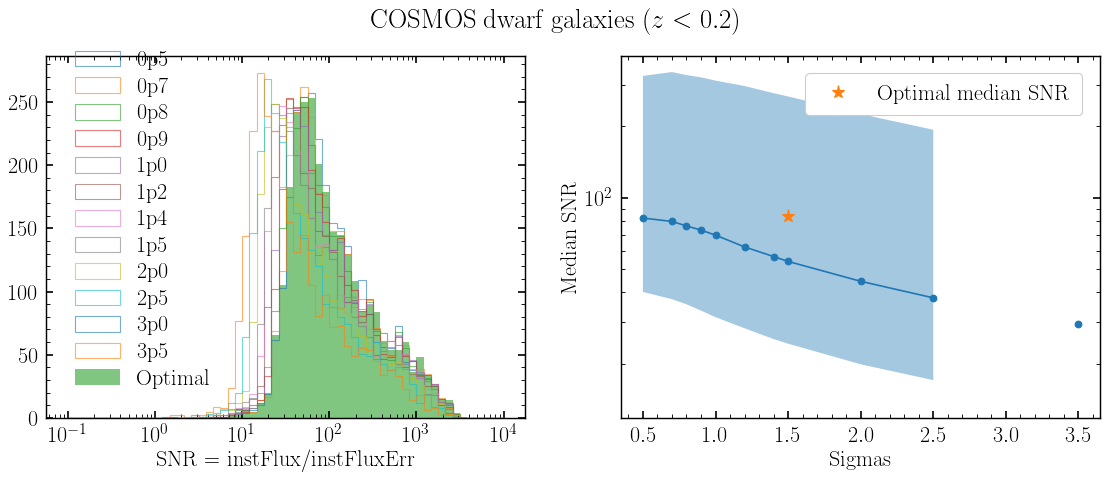

In [323]:
fig, ax = plt.subplots(1, 2, figsize=(17,6))
bins = np.logspace(-1, 4, 61)

statistic_list = []
statistic_upper_list, statistic_lower_list = [], []

for baseName in baseNames:
    label = baseName.replace('i_gaap','').replace('Flux','')
    histtype='stepfilled' if "Optimal" in baseName else 'step'
    snr = cat[baseName][good_objects] / cat[baseName+"Err"][good_objects]
    ax[0].hist(snr, bins=bins, histtype=histtype, label=label, alpha=0.6)
    statistic = np.nanpercentile(snr, 50)
    if "Optimal" in label:
        optStatistic = np.nanpercentile(snr, 50)
    if not ("PsfFlux" in label or "Optimal" in label):
        statistic_list.append(statistic)
        statistic_upper_list.append(np.percentile(snr, 84))
        statistic_lower_list.append(np.percentile(snr, 16))

    
ax[0].set_xscale('log')
ax[0].set_xlabel("SNR = instFlux/instFluxErr")
#ax[0].set_yscale('log')
ax[0].legend(loc='best')

sigmas = [0.5, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.5, 2.0, 2.5, 3.0, 3.5]
ax[1].plot(sigmas, statistic_list, 'o-')
ax[1].fill_between(sigmas, statistic_upper_list, statistic_lower_list, alpha=0.4)
ax[1].plot(1.5, optStatistic, "*", markersize=12, label='Optimal median SNR')
ax[1].set_yscale('log')
plt.legend(frameon=True)
ax[1].set_ylabel("Median SNR")
ax[1].set_xlabel("Sigmas")

plt.suptitle(r'COSMOS dwarf galaxies ($z < 0.2$)')

Text(0.5, 0.98, 'COSMOS dwarf galaxies ($\\log M_\\star < 9$)')

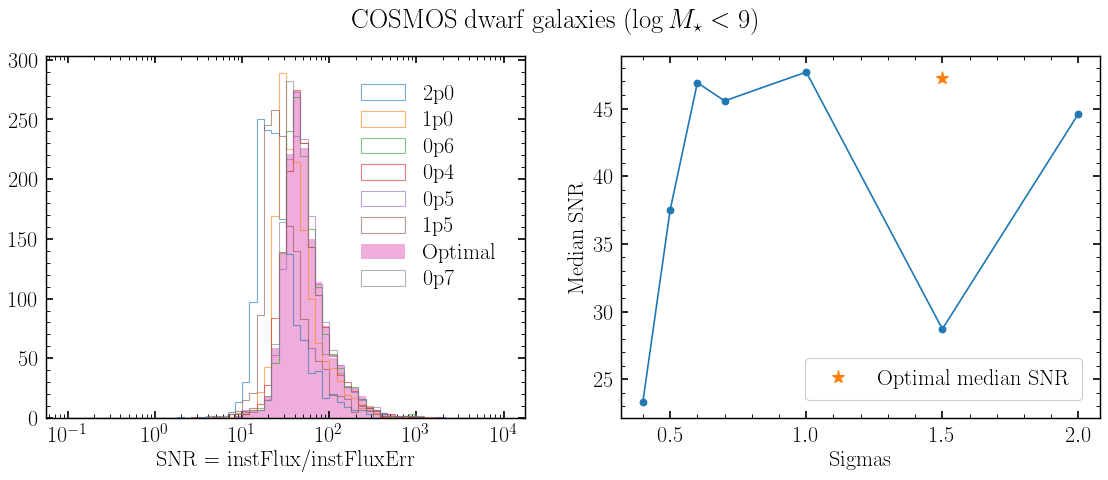

In [193]:
fig, ax = plt.subplots(1, 2, figsize=(17,6))
bins = np.logspace(-1, 4, 61)

statistic_list = []
statistic_upper_list, statistic_lower_list = [], []

for baseName in baseNames:
    label = baseName.replace('i_gaap','').replace('Flux','')
    histtype='stepfilled' if "Optimal" in baseName else 'step'
    snr = cat[baseName][good_objects] / cat[baseName+"Err"][good_objects]
    ax[0].hist(snr, bins=bins, histtype=histtype, label=label, alpha=0.6)
    statistic = np.nanpercentile(snr, 50)
    if "Optimal" in label:
        optStatistic = np.nanpercentile(snr, 50)
    if not ("PsfFlux" in label or "Optimal" in label):
        statistic_list.append(statistic)
        statistic_upper_list.append(np.percentile(snr, 84))
        statistic_lower_list.append(np.percentile(snr, 16))

    
ax[0].set_xscale('log')
ax[0].set_xlabel("SNR = instFlux/instFluxErr")
#ax[0].set_yscale('log')
ax[0].legend(loc='best')

sigmas = [0.4, 0.5, 0.6, 0.7, 1.0, 1.5, 2.0]
ax[1].plot(sigmas, statistic_list, 'o-')
# ax[1].fill_between(sigmas, statistic_upper_list, statistic_lower_list, alpha=0.4)
ax[1].plot(1.5, optStatistic, "*", markersize=12, label='Optimal median SNR')
plt.legend(frameon=True)
ax[1].set_ylabel("Median SNR")
ax[1].set_xlabel("Sigmas")

plt.suptitle(r'COSMOS dwarf galaxies ($\log M_\star < 9$)')

Text(0.5, 0, 'Sigmas')

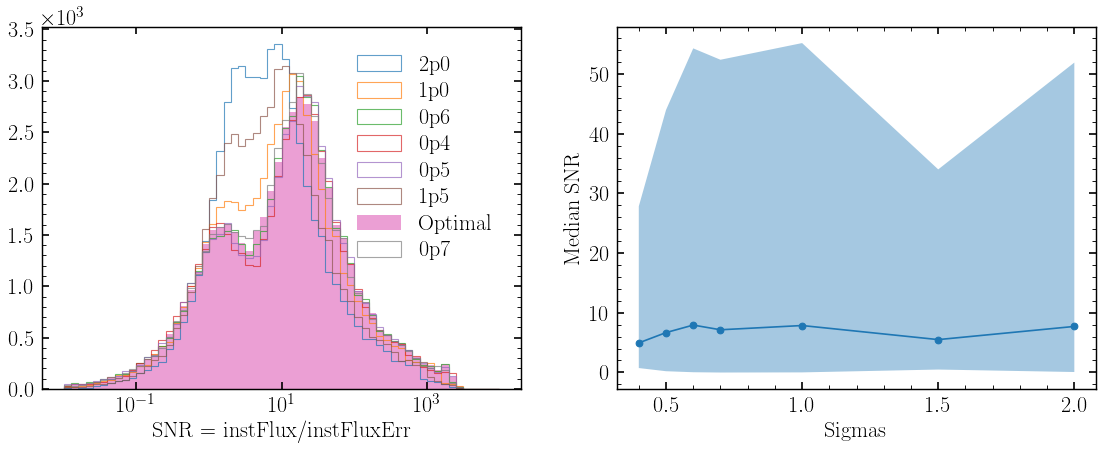

In [169]:
fig, ax = plt.subplots(1, 2, figsize=(17,6))
bins = np.logspace(-2, 4, 61)

statistic_list = []
statistic_upper_list, statistic_lower_list = [], []

for baseName in baseNames:
    label = baseName.replace('i_gaap','').replace('Flux','')
    histtype='stepfilled' if "Optimal" in baseName else 'step'
    snr = cat[baseName][good_objects] / cat[baseName+"Err"][good_objects]
    ax[0].hist(snr, bins=bins, histtype=histtype, label=label, alpha=0.7)
    statistic = np.nanpercentile(snr, 50)
    if "Optimal" in label:
        optStatistic = np.nanpercentile(snr, 50)
    if not ("PsfFlux" in label or "Optimal" in label):
        statistic_list.append(statistic)
        statistic_upper_list.append(np.percentile(snr, 84))
        statistic_lower_list.append(np.percentile(snr, 16))

    
ax[0].set_xscale('log')
ax[0].set_xlabel("SNR = instFlux/instFluxErr")
#ax[0].set_yscale('log')
ax[0].legend(loc='best')

sigmas = [0.4, 0.5, 0.6, 0.7, 1.0, 1.5, 2.0]
ax[1].plot(sigmas, statistic_list, 'o-')
ax[1].fill_between(sigmas, statistic_upper_list, statistic_lower_list, alpha=0.4)
# ax[1].plot(3.6, optStatistic, "*", markersize=12)
ax[1].set_ylabel("Median SNR")
ax[1].set_xlabel("Sigmas")

### Match with S20A blendedness

In [104]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from tqdm import tqdm

In [ ]:
tract = 9813
filedir = f'/projects/MERIAN/repo/S20A/gaapTable/{tract}/'
for patch in tqdm(common_patches):

    patch_name = f'{patch[0]},{patch[1]}'
    filename = os.path.join(filedir, patch_name, f'objectTable_{tract}_{patch_name}_S20A.fits')
    gaapCat = Table.read(filename)
    filename = os.path.join(filedir, patch_name, f'S20A_blendedness_{patch_name}.fits')
    blendCat = Table.read(filename)

    old_cols = [f'm_{filt}_blendedness_abs' for filt in 'grizy'] + [f'm_{filt}_blendedness_flag' for filt in 'grizy']
    new_cols = [f'{filt}_blendedness' for filt in 'grizy'] + [f'{filt}_blendedness_flag' for filt in 'grizy']
    blendCat.rename_columns(old_cols, new_cols)
    
    _gaap = SkyCoord(gaapCat['coord_ra'], gaapCat['coord_dec'], unit='deg')
    _blend = SkyCoord(blendCat['ra'], blendCat['dec'], unit='deg')
    ind, dist, _ = _blend.match_to_catalog_sky(_gaap)

    for col in new_cols:
        gaapCat[col] = np.ones(len(gaapCat)) * np.nan
        gaapCat[col][ind[dist < 1.5 * u.arcsec]] = blendCat[dist < 1.5 * u.arcsec][col]
        
    filename = os.path.join(filedir, patch_name, f'objectTable_{tract}_{patch_name}_S20A.fits')
    gaapCat.write(filename, overwrite=True)

In [132]:
filedir = '/projects/MERIAN/repo/S20A/gaapTable/9813/'

patch = (3,0)
patch_name = f'{patch[0]},{patch[1]}'
filename = os.path.join(filedir, patch_name, f'objectTable_9813_{patch_name}_S20A.fits')
gaapCat = Table.read(filename)
filename = os.path.join(filedir, patch_name, f'S20A_blendedness_{patch_name}.fits')
blendCat = Table.read(filename)

old_cols = [f'm_{filt}_blendedness_abs' for filt in 'grizy'] + [f'm_{filt}_blendedness_flag' for filt in 'grizy']
new_cols = [f'{filt}_blendedness' for filt in 'grizy'] + [f'{filt}_blendedness_flag' for filt in 'grizy']
blendCat.rename_columns(old_cols, new_cols)

In [133]:
_gaap = SkyCoord(gaapCat['coord_ra'], gaapCat['coord_dec'], unit='deg')
_blend = SkyCoord(blendCat['ra'], blendCat['dec'], unit='deg')
ind, dist, _ = _blend.match_to_catalog_sky(_gaap)

for col in new_cols:
    gaapCat[col] = np.ones(len(gaapCat)) * np.nan
    gaapCat[col][ind[dist < 1.5 * u.arcsec]] = blendCat[dist < 1.5 * u.arcsec][col]

In [134]:
filename = os.path.join(filedir, patch_name, f'objectTable_9813_{patch_name}_S20A.fits')
gaapCat.write(filename, overwrite=True)